In [17]:
import torch
import torch.nn as nn
import string
import numpy as np
import random
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from IPython.core.debugger import set_trace
import IPython
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def get_digits(timesteps):
    rand_indices = [random.randint(0, len(string.digits)-1) for _ in range(timesteps)]
    rand_nums = list(map(lambda x: int(string.digits[x]), rand_indices))
    sorted_rand_nums = sorted(rand_nums)
    
    return rand_nums, sorted_rand_nums

get_digits(8)

([4, 1, 2, 5, 1, 5, 3, 1], [1, 1, 1, 2, 3, 4, 5, 5])

In [3]:
def generate_training_data(timesteps, num_examples):
    x = list(); y = list()
    
    for _ in range(num_examples):
        digit, sorted_digit = get_digits(timesteps)
        x.append(digit); y.append(sorted_digit)
        
    random_id = random.randint(0, len(x))
    print(x[random_id], y[random_id])
    
    return x, y

In [4]:
def encode_data(x, y):
    features_dim = 10
    one_hot_x = F.one_hot(torch.tensor(x), num_classes=features_dim)
    one_hot_y = F.one_hot(torch.tensor(y), num_classes=features_dim)
    
    return one_hot_x.to(torch.float32), one_hot_y.to(torch.float32)

In [5]:
x, y = generate_training_data(8, 10000)
one_hot_x, one_hot_y = encode_data(x, y)
print(one_hot_x.dtype, one_hot_y.dtype)

val_x, val_y = generate_training_data(8, 1000)
val_x, val_y = encode_data(val_x, val_y)
print(val_x.shape, val_y.shape)

[9, 1, 1, 1, 7, 4, 1, 9] [1, 1, 1, 1, 4, 7, 9, 9]
torch.float32 torch.float32
[8, 0, 2, 5, 4, 5, 9, 1] [0, 1, 2, 4, 5, 5, 8, 9]
torch.Size([1000, 8, 10]) torch.Size([1000, 8, 10])


In [6]:
class CustomData(Dataset):
    def __init__(self, x_data, y_data):
        super().__init__()
        self.x_data = x_data
        self.y_data = y_data
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]
    
dataset = CustomData(one_hot_x, one_hot_y)
val_dataset = CustomData(val_x, val_y)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [7]:
class AttentionModel(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, input_features_dim, output_features_dim, timesteps, num_training):
        super().__init__()
        self.timesteps = timesteps
        self.input_features_dim = input_features_dim
        
        self.densor1 = nn.Linear(decoder_dim+(2*encoder_dim), 10)
        self.tanh = nn.Tanh()
        self.densor2 = nn.Linear(10, 1)
        self.softmax = nn.Softmax(dim=1)
        
        self.pre_attention_lstm = nn.LSTM(input_size=input_features_dim, hidden_size=encoder_dim, batch_first=True, bidirectional=True)
        self.post_attention_lstm = nn.LSTM(input_size=encoder_dim*2, hidden_size=decoder_dim, batch_first=True)
        self.output_layer = nn.Linear(decoder_dim, output_features_dim)
        
        
    def forward(self, x, s0, c0):
        # x-> (B, timesteps, features) -> (128, 10, 26)
        # s0, c0 -> (1, B, decoder_dim) -> (1, 128, 16)
        #set_trace()
        self.s = s0; self.c = c0
        encoder_hidden_states, (hn, cn) = self.pre_attention_lstm(x) #hidden_states: (B, timesteps, encoder_dim*2) -> (128, 10, 16)
        outputs = list()
        
        for t in range(self.timesteps):
            context = self.one_step_attention(encoder_hidden_states) # (B, timesteps, 2*encoder_dim)
            _, (self.s, self.c )= self.post_attention_lstm(context, (self.s, self.c)) # _ -> (B, timesteps, decoder_dim)
            output = self.output_layer(self.s) # (1, B, output_features_dim) -> (1, 128, 26)
            outputs.append(output) # (timesteps, B, output_features_dim) -> (10, 128, 26)
        
        return outputs
    
    def one_step_attention(self, encoder_hidden_states):
        # encoder_Hidden_states -> (B, timesteps, 2*encoder_dim) -> (128, 10, 16)
        # self.s -> (1, B, decoder_dim)
        # 1. first the hidden state for decoder must be repeated to match the hidden states of encoder
        # self.s -> (timesteps, B, decoder_dim) -> permute -> (B, timesteps, decoder_dim)
        # 2. then concatenate the hidden state for decoder and the hidden state for encoder -> (B, timesteps, 2*encoder_dim + decoder_dim)
        # pass it through the first dense layer
        # pass it through the second dense layer
        # use softmax to decide which hidden state of encoder is the most important
        # use dot product to find the important hidden state of encoder and feed it as input to the decoder
        hidden_decoder = self.s.repeat(self.timesteps, 1, 1).permute(1, 0, 2) # (B, timesteps, decoder_dim) -> (128, 10, 16)
        concat = torch.concatenate([encoder_hidden_states, hidden_decoder], dim=-1) # (B, timesteps, 2*encoder_dim + decoder_dim) -> (128, 10, 32)
        e = self.tanh(self.densor1(concat)) # (B, timesteps, 10) -> (128, 10, 10)
        energies = self.softmax(self.densor2(e)) # (B, timesteps, 1) -> (128, 10, 1)
        # let's if without permute in next step if the code converges
        energies = energies.repeat(1, 1, 10).permute(0, 2, 1) # (B, timesteps, 10) -> (B, 10, 10)
        context = torch.bmm(energies, encoder_hidden_states) # (B, timesteps, timesteps) @ (B, timesteps, 2*encoder_dim) -> (B, timesteps, 2*encoder_dim)
        
        return context
        
    def predict(self, x):
        assert len(x) == self.timesteps
        one_hot = F.one_hot(torch.tensor(x), num_classes=self.input_features_dim)
        s0 = torch.zeros(1, 1, decoder_dim); c0 = torch.zeros(1, 1, decoder_dim)
        one_hot = one_hot.unsqueeze(0)
        pred = self.forward(one_hot.to(torch.float32), s0, c0)
        pred = [torch.argmax(t, dim=-1).tolist()[0][0] for t in pred]
        return pred

In [8]:
def calculate_loss(y_true, y_pred):
    ce = nn.CrossEntropyLoss()
    total = 0
    for target, logit in zip(list(y_true), list(y_pred)):
        loss = ce(logit[0], target)
        total += loss
        
    return total

In [9]:
imp = list()

def hook_function(module, input, output):
    if not am.training:
        imp.append(output[0].flatten().tolist())

In [10]:
features = 10
encoder_dim = 8
decoder_dim = 16
input_features_dim = features
output_features_dim = features
timesteps = 8
num_training = 10000
epochs = 40

attention_dict = dict()

s0, c0 = torch.zeros(1, num_training, decoder_dim), torch.zeros(1, num_training, decoder_dim)

am = AttentionModel(encoder_dim, decoder_dim, input_features_dim, output_features_dim, timesteps, num_training)
opt = optim.Adam(am.parameters())

In [11]:
for name, layer in am.named_children():
    if name == 'softmax':
        print(layer)
        handle = layer.register_forward_hook(hook_function)

Softmax(dim=1)


In [12]:
for epoch in range(epochs):
    am.train()
    train_loss = list()
    for i, (inputs, target) in enumerate(train_loader):
        #set_trace()
        target = target.permute(1, 0, 2)
        batch_size = inputs.size(0)
        s0 = torch.zeros(1, batch_size, decoder_dim); c0 = torch.zeros(1, batch_size, decoder_dim)
        outputs = am(inputs, s0, c0)
        
        opt.zero_grad()
        
        total_loss = calculate_loss(target, outputs)
        train_loss.append(total_loss)
        
        total_loss.backward()
        opt.step()
        
    print(f'Epoch {epoch}:: Train Loss {torch.mean(torch.tensor(train_loss))}')
    
    am.eval()
    with torch.no_grad():
        
#         s0 = torch.zeros(1, 1000, decoder_dim); c0 = torch.zeros(1, 1000, decoder_dim)
#         out = am(val_x, s0, c0)
        
#         val_loss = calculate_loss(val_y.permute(1, 0, 2), out)
        
#         print(f'Epoch {epoch}:: Val Loss {val_loss}')
        test = [1, 9, 4, 3, 8, 7, 5, 6]
        #set_trace()
        pred = am.predict(test)
        attention_dict[f'Epoch {epoch}'] = np.array(imp)
        imp = list()
        print(f'Input {test} --> Output {pred}')
        print()
    

Epoch 0:: Train Loss 18.358272552490234
Input [1, 9, 4, 3, 8, 7, 5, 6] --> Output [8, 8, 1, 1, 1, 1, 1, 1]

Epoch 1:: Train Loss 16.833295822143555
Input [1, 9, 4, 3, 8, 7, 5, 6] --> Output [0, 3, 3, 8, 9, 9, 9, 9]

Epoch 2:: Train Loss 12.472617149353027
Input [1, 9, 4, 3, 8, 7, 5, 6] --> Output [0, 3, 3, 5, 6, 7, 9, 9]

Epoch 3:: Train Loss 9.79032039642334
Input [1, 9, 4, 3, 8, 7, 5, 6] --> Output [0, 3, 3, 5, 6, 7, 9, 9]

Epoch 4:: Train Loss 8.18410587310791
Input [1, 9, 4, 3, 8, 7, 5, 6] --> Output [0, 3, 3, 5, 6, 7, 9, 9]

Epoch 5:: Train Loss 7.161725997924805
Input [1, 9, 4, 3, 8, 7, 5, 6] --> Output [1, 3, 4, 5, 6, 7, 9, 9]

Epoch 6:: Train Loss 6.386471271514893
Input [1, 9, 4, 3, 8, 7, 5, 6] --> Output [1, 3, 4, 5, 6, 7, 8, 9]

Epoch 7:: Train Loss 5.746674537658691
Input [1, 9, 4, 3, 8, 7, 5, 6] --> Output [1, 3, 4, 5, 6, 7, 8, 9]

Epoch 8:: Train Loss 5.297490119934082
Input [1, 9, 4, 3, 8, 7, 5, 6] --> Output [1, 3, 4, 5, 6, 7, 8, 9]

Epoch 9:: Train Loss 4.8875432014465

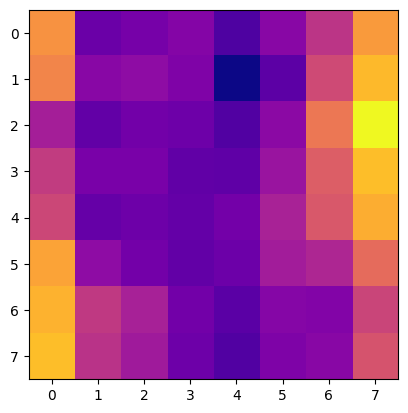

In [13]:
plt.imshow(attention_dict['Epoch 39'], cmap='plasma')

In [15]:
for key in attention_dict:
    plt.imshow(attention_dict[key], cmap='plasma')
    plt.title(key)
    plt.title(f"Attention Heatmap sort digits \n {key}")
    plt.xticks(range(len(test)), labels=test)
    plt.yticks(range(len(test)), labels=test)
    plt.colorbar()
    
    file_name = f'{key}.png'
    plt.savefig(f'/kaggle/working/{file_name}')
    plt.close()

In [18]:
frames = list()

for key in attention_dict:
    img = Image.open(f'/kaggle/working/{key}.png')
    img = img.convert('RGB')
    
    frames.append(img)
    
frames[0].save('sort_digits_animation.gif', save_all=True, append_images=frames[1:], duration=150, loop=0)